In [164]:
import numpy as np
import cv2
from keras.models import load_model
import matplotlib.pyplot as plt
from matplotlib import cm
import detect_edges
%matplotlib inline

In [165]:
scanner = load_model('scanner.keras')

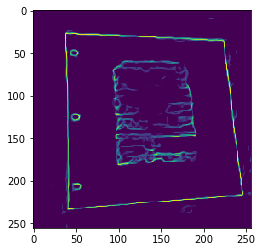

In [166]:
image_document = 'page.jpg'
edges_page = detect_edges.predict_custom_image(image_document, model=scanner)

plt.imshow(edges_page)

In [216]:
new_page = edges_page > 0.1
new_page = new_page.astype(int)

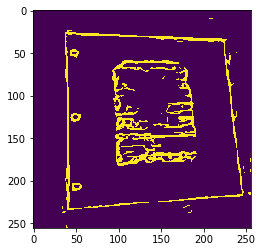

In [217]:
plt.imshow(new_page)

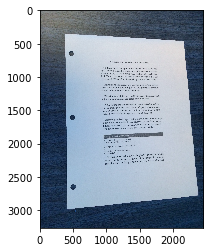

In [249]:
page_actual = cv2.imread('page.jpg')
plt.imshow(page_actual)

In [ ]:
page_resized = cv2.resize(page_actual, (256,256))

In [250]:
page_resized.shape

(256, 256, 3)

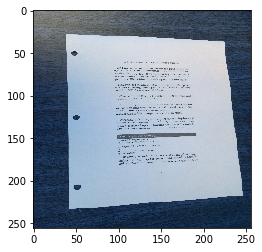

In [251]:
plt.imshow(page_resized)

In [218]:
import numpy as np
from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line as _prob_hough_line)


def _probabilistic_hough_line(image, threshold=0.5, line_length=50, line_gap=10,
                             theta=None):
    
    if image.ndim != 2:
        raise ValueError('The input image `image` must be 2D.')

    if theta is None:
        theta = np.pi / 2 - np.arange(180) / 180.0 * np.pi

    return _prob_hough_line(image, threshold=threshold, line_length=line_length,
                            line_gap=line_gap, theta=theta)


In [219]:
import numpy as np
import imageio
import math
from skimage.transform import (hough_line, hough_line_peaks)

def rgb2gray(rgb):
    return np.dot(rgb[..., :3], [0.299, 0.587, 0.114]).astype(np.uint8)


def hough_line(img, angle_step=1, lines_are_white=True, value_threshold=0.3):
   
    # Rho and Theta ranges
    thetas = np.deg2rad(np.arange(-90.0, 90.0, angle_step))
    width, height = img.shape
    diag_len = int(round(math.sqrt(width * width + height * height)))
    rhos = np.linspace(-diag_len, diag_len, diag_len * 2)

    # Cache some resuable values
    cos_t = np.cos(thetas)
    sin_t = np.sin(thetas)
    num_thetas = len(thetas)

    # Hough accumulator array of theta vs rho
    accumulator = np.zeros((2 * diag_len, num_thetas), dtype=np.uint8)
    # (row, col) indexes to edges
    are_edges = img > value_threshold if lines_are_white else img < value_threshold
    y_idxs, x_idxs = np.nonzero(are_edges)

    # Vote in the hough accumulator
    for i in range(len(x_idxs)):
        x = x_idxs[i]
        y = y_idxs[i]

        for t_idx in range(num_thetas):
            # Calculate rho. diag_len is added for a positive index
            rho = diag_len + int(round(x * cos_t[t_idx] + y * sin_t[t_idx]))
            accumulator[rho, t_idx] += 1

    return accumulator, thetas, rhos


def show_hough_line(img, accumulator, thetas, rhos, save_path=None):
    
    fig, ax = plt.subplots(1, 3, figsize=(10, 10))

    ax[0].imshow(img, cmap=plt.cm.gray)
    ax[0].set_title('Input image')
    ax[0].axis('image')

    ax[1].imshow(
        accumulator, cmap='jet',
        extent=[np.rad2deg(thetas[-1]), np.rad2deg(thetas[0]), rhos[-1], rhos[0]])
    ax[1].set_aspect('equal', adjustable='box')
    ax[1].set_title('Hough transform')
    ax[1].set_xlabel('Angles (degrees)')
    ax[1].set_ylabel('Distance (pixels)')
    ax[1].axis('image')

    #ax[2].imshow(image, cmap=cm.gray)
    for _, angle, dist in zip(*hough_line_peaks(accumulator, thetas, rhos)):
        y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
        y1 = (dist - img.shape[1] * np.cos(angle)) / np.sin(angle)
        ax[2].plot((0, img.shape[1]), (y0, y1), '-r')
    ax[2].set_xlim((0, img.shape[1]))
    ax[2].set_ylim((img.shape[0], 0))
    ax[2].set_axis_off()
    ax[2].set_title('Detected lines')

    # plt.axis('off')
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')
plt.show()

In [204]:
accumulator, thetas, rhos = hough_line(edges_page)

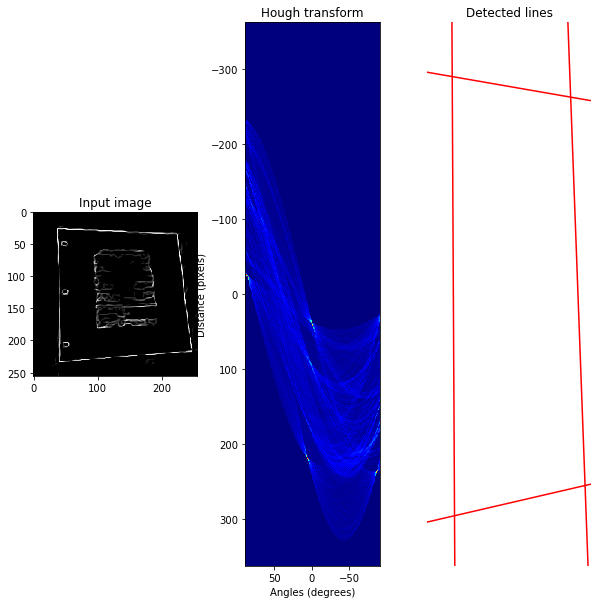

In [205]:
show_hough_line(edges_page, accumulator,thetas,rhos, save_path='page_output.png')

In [233]:
lines = _probabilistic_hough_line(new_page)
len(lines)

74

In [234]:
lines_page = np.array(lines, dtype = 'int32')

In [235]:
lines_page.shape

(74, 2, 2)

In [236]:
lines_page.resize(74,1,4)
lines_page.shape

(74, 1, 4)

In [252]:

def find_intersection(line1, line2):
    # extract points
    x1, y1, x2, y2 = line1[0]
    x3, y3, x4, y4 = line2[0]
    # compute determinant
    Px = ((x1*y2 - y1*x2)*(x3-x4) - (x1-x2)*(x3*y4 - y3*x4))/  \
        ((x1-x2)*(y3-y4) - (y1-y2)*(x3-x4))
    Py = ((x1*y2 - y1*x2)*(y3-y4) - (y1-y2)*(x3*y4 - y3*x4))/  \
        ((x1-x2)*(y3-y4) - (y1-y2)*(x3-x4))
    return Px, Py

def segment_lines(lines, delta):
    h_lines = []
    v_lines = []
    for line in lines:
        for x1, y1, x2, y2 in line:
            if abs(x2-x1) < delta: # x-values are near; line is vertical
                v_lines.append(line)
            elif abs(y2-y1) < delta: # y-values are near; line is horizontal
                h_lines.append(line)
    return h_lines, v_lines


In [268]:
# segment the lines
delta = 20
h_lines, v_lines = segment_lines(lines_page, delta)

In [269]:
# draw the segmented lines
houghimg = page_resized.copy()
for line in h_lines:
    for x1, y1, x2, y2 in line:
        color = [0,0,255] # color hoz lines red
        cv2.line(houghimg, (x1, y1), (x2, y2), color=color, thickness=4)
for line in v_lines:
    for x1, y1, x2, y2 in line:
        color = [255,0,0] # color vert lines blue
        cv2.line(houghimg, (x1, y1), (x2, y2), color=color, thickness=4)

#cv2.imshow("Segmented Hough Lines", houghimg)
#cv2.waitKey(1)
cv2.imwrite('hough_page.png', houghimg)


True

In [270]:
# find the line intersection points
Px = []
Py = []
for h_line in h_lines:
    for v_line in v_lines:
        px, py = find_intersection(h_line, v_line)
        Px.append(px)
        Py.append(py)

# draw the intersection points
intersectsimg = page_resized.copy()
for cx, cy in zip(Px, Py):
    cx = np.round(cx).astype(int)
    cy = np.round(cy).astype(int)
    color = np.random.randint(0,255,3).tolist() # random colors
    cv2.circle(intersectsimg, (cx, cy), radius=2, color=color, thickness=-1) # -1: filled circle

#cv2.imshow("Intersections", intersectsimg)
#cv2.waitKey(1)
cv2.imwrite('intersections_page.png', intersectsimg)


True

In [271]:
import math
def dot(vA, vB):
    return vA[0]*vB[0]+vA[1]*vB[1]
def ang(lineA, lineB):
    line_img = receipt_rotated.copy()
    color = [0,255,0]
    x1, y1, x2, y2 = lineA[0]
    x3, y3, x4, y4 = lineB[0]
    # Get nicer vector form
    vA = [(x1-x2), (y1-y2)]
    vB = [(x3-x4), (y3-y4)]
    # Get dot prod
    dot_prod = dot(vA, vB)
    # Get magnitudes
    magA = dot(vA, vA)**0.5
    magB = dot(vB, vB)**0.5
    # Get cosine value
    cos_ = dot_prod/magA/magB
    # Get angle in radians and then convert to degrees
    angle = math.acos(dot_prod/magB/magA)
    i = 1
    # Basically doing angle <- angle mod 360
    ang_deg = math.degrees(angle)%360
    if ang_deg-180>=0:
        # As in if statement
        ang_deg = 360 - ang_deg
    else: 

        pass
        
    return(ang_deg,x1,y1,x2,y2,x3,y3,x4,y4)

In [272]:
angle =[]
bx1 = []
by1 = []
bx2 = []
by2 = []
bx3 = []
by3 = []
bx4 = []
by4 = []
for h_line in h_lines:
    for v_line in v_lines:
        angl,vx1,vy1,vx2,vy2,vx3,vy3,vx4,vy4 = ang(h_line, v_line)
        angle.append(angl)
        bx1.append(vx1)
        by1.append(vy1)
        bx2.append(vx2)
        by2.append(vy2)
        bx3.append(vx3)
        by3.append(vy3)
        bx4.append(vx4)
        by4.append(vy4)
line_img = page_resized.copy()
for ang_deg , cx1 , cy1 , cx2 ,cy2 , cx3 ,cy3 , cx4 , cy4 in zip(angle, bx1 , by1 , bx2 , by2, bx3, by3, bx4, by4):
    if ang_deg > 89 and ang_deg < 91:
        cv2.line(line_img, (cx1, cy1), (cx2, cy2), color=(0,255,0), thickness=5)
        cv2.line(line_img, (cx3, cy3), (cx4, cy4), color=(0,255,0), thickness=5)

#cv2.imshow("Intersections", intersectsimg)
#cv2.waitKey(1)
cv2.imwrite('page_contour.png', line_img)

True